# Hierarchical Agent Teams

In our previous example ([Agent Supervisor](../agent_supervisor)), we introduced the concept of a single [supervisor node](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

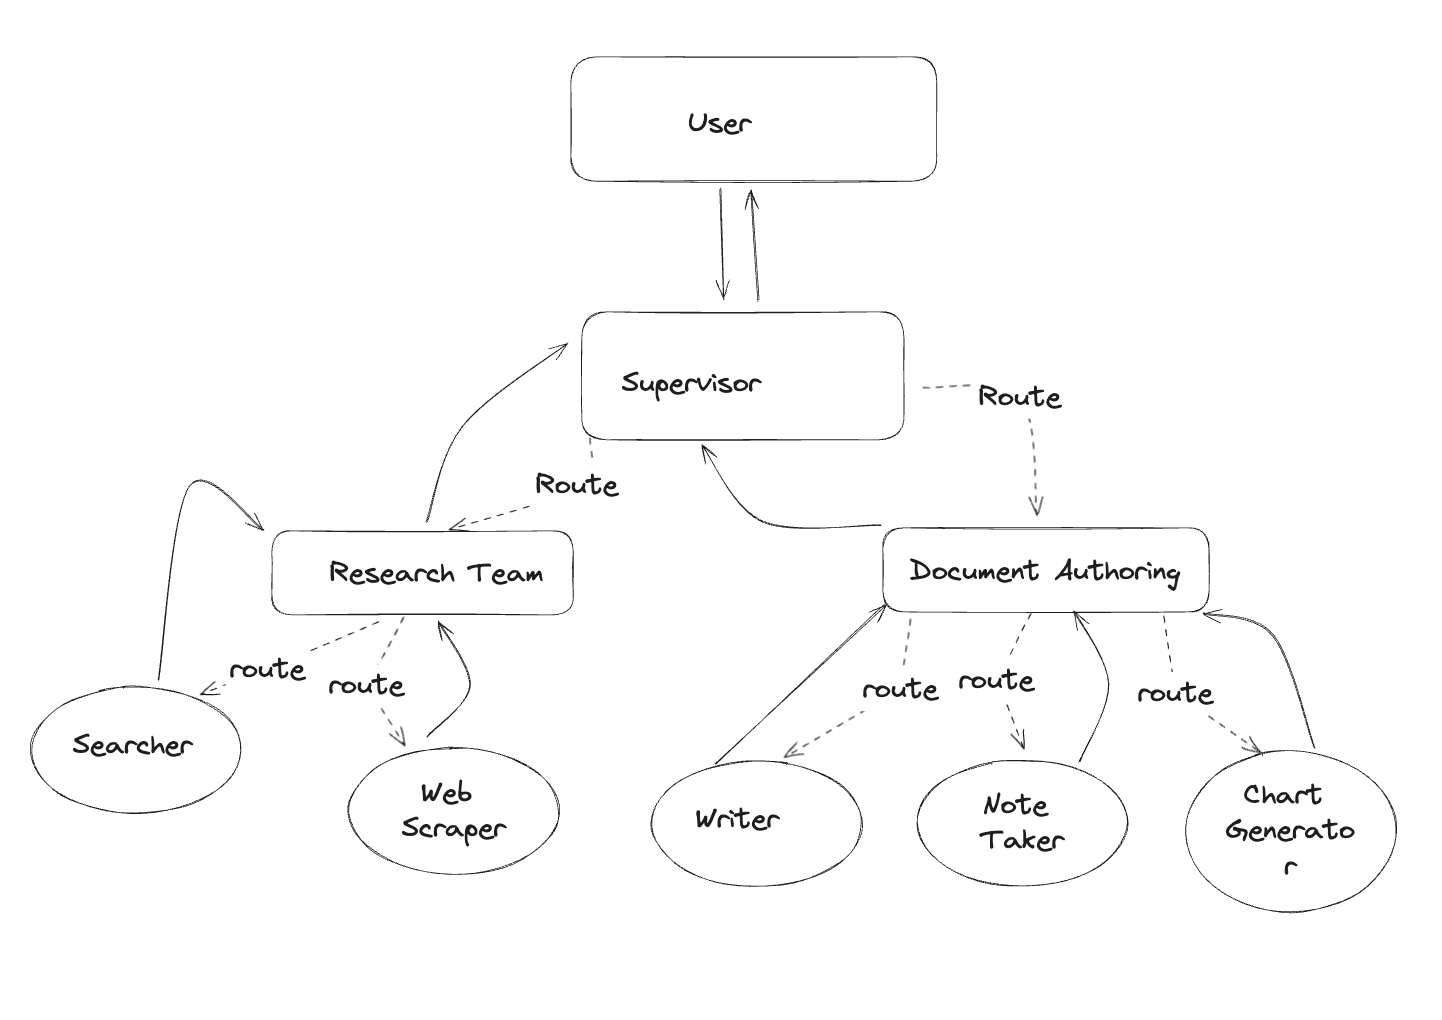

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

## Setup

First, let's install our required packages and set our API keys

In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**ResearchTeam tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [3]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [4]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [5]:
from langgraph.prebuilt.chat_agent_executor import AgentRouterState, make_agent_node, add_entrypoint_router
from langgraph.prebuilt.handoff import handoff

In [6]:
from langchain_openai import ChatOpenAI

In [7]:
model = ChatOpenAI(model="gpt-4o", model_kwargs=dict(parallel_tool_calls=False))

In [8]:
from langgraph.checkpoint.memory import MemorySaver

In [9]:
@tool
def search(query: str):
    """Search the web"""
    return "Taylor Swift is touring in Nov 2024"

In [10]:
def keep_last_message(state):
    return {**state, "messages": [HumanMessage(content=state["messages"][-1].content)]}

In [13]:
from langgraph.graph import StateGraph, START

In [14]:
builder = StateGraph(AgentRouterState)

search_agent_tool = handoff("search", tool_message="Transferred to search agent", name="transfer_to_search", description="Call search to do web search")
web_scraper_agent_tool = handoff("web_scraper", tool_message="Transferred to web scraper agent", name="transfer_to_web_scraper", description="Call web scraper to read a website")

supervisor = make_agent_node(
    model, 
    [search_agent_tool, web_scraper_agent_tool],
    state_schema=AgentRouterState,
    state_modifier="You are a supervisor tasked with managing a conversation between the following workers: ['search', 'web_scraper']."
)
search_agent = make_agent_node(model, [tavily_tool], state_schema=AgentRouterState, output_processor=keep_last_message)
web_scraper_agent = make_agent_node(model, [scrape_webpages], state_schema=AgentRouterState, output_processor=keep_last_message)

builder.add_node("supervisor", supervisor)
builder.add_node("search", search_agent)
builder.add_node("web_scraper", web_scraper_agent)
builder.add_edge(START, "supervisor")
# add explicit edges back to the supervisor
builder.add_edge("search", "supervisor")
builder.add_edge("web_scraper", "supervisor")
memory = MemorySaver()
research_graph = builder.compile(checkpointer=memory)

In [15]:
from langchain_core.messages import HumanMessage

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

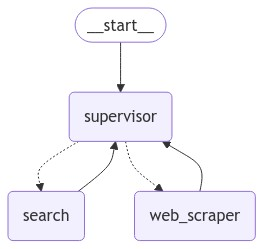

In [16]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [17]:
config = {"configurable": {"thread_id": "1"}}

In [18]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    config,
):
    print(s)
    print("---")

{'supervisor': {'messages': [HumanMessage(content="when is Taylor Swift's next tour?", additional_kwargs={}, response_metadata={}, id='78c53262-87ce-4425-909c-47d84a5bb612'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_liQN4cvJO0IzlnLOtXizzKp5', 'function': {'arguments': '{}', 'name': 'transfer_to_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 89, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d75d78ec-7ad0-411d-8112-26c2d0af8ba2-0', tool_calls=[{'name': 'transfer_to_search', 'args': {}, 'id': 'call_liQN4cvJO0IzlnLOtXizzKp5', 'type': 'tool_call'}], usage_metadata={'input_token

In [19]:
research_graph.get_state(config).values["messages"]

[HumanMessage(content="when is Taylor Swift's next tour?", additional_kwargs={}, response_metadata={}, id='78c53262-87ce-4425-909c-47d84a5bb612'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_liQN4cvJO0IzlnLOtXizzKp5', 'function': {'arguments': '{}', 'name': 'transfer_to_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 89, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d75d78ec-7ad0-411d-8112-26c2d0af8ba2-0', tool_calls=[{'name': 'transfer_to_search', 'args': {}, 'id': 'call_liQN4cvJO0IzlnLOtXizzKp5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 89, 'output_tokens': 11

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [33]:
doc_writer_tool = handoff("doc_writer", tool_message="Transferred to doc writer", name="transfer_to_doc_writer", description="Write documents")
note_taker_tool = handoff("note_taker", tool_message="Transferred to note taker", name="transfer_to_note_taker", description="Create outlines")
chart_generator_tool = handoff("chart_generator", tool_message="Transferred to chart generator", name="transfer_to_chart_generator", description="Generate charts")

doc_writing_supervisor = make_agent_node(
    model, 
    [doc_writer_tool, note_taker_tool, chart_generator_tool],
    state_schema=AgentRouterState,
    state_modifier='You are a supervisor tasked with managing a conversation between the following workers: ["doc_writer", "note_taker", "chart_generator"].'
)
doc_writer_agent = make_agent_node(
    model,
    [write_document, edit_document, read_document],
    output_processor=keep_last_message,
    state_schema=AgentRouterState,
    state_modifier="You can read, write and edit documents based on note-taker's outlines. Don't ask follow-up questions."
)
note_taking_agent = make_agent_node(
    model, 
    [create_outline, read_document],
    state_schema=AgentRouterState,
    output_processor=keep_last_message, 
    state_modifier="You can read documents and create outlines for the document writer. Don't ask follow-up questions."
)
chart_generating_agent = make_agent_node(
    model, 
    [read_document, python_repl_tool],
    state_schema=AgentRouterState,
    output_processor=keep_last_message,
)

# Create the graph here
paper_writing_builder = StateGraph(AgentRouterState)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor)
paper_writing_builder.add_node("doc_writer", doc_writer_agent)
paper_writing_builder.add_node("note_taker", note_taking_agent)
paper_writing_builder.add_node("chart_generator", chart_generating_agent)

# Define the control flow
paper_writing_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
paper_writing_builder.add_edge("doc_writer", "supervisor")
paper_writing_builder.add_edge("note_taker", "supervisor")
paper_writing_builder.add_edge("chart_generator", "supervisor")

memory = MemorySaver()
paper_writing_graph = paper_writing_builder.compile(checkpointer=memory)

With the objects themselves created, we can form the graph.

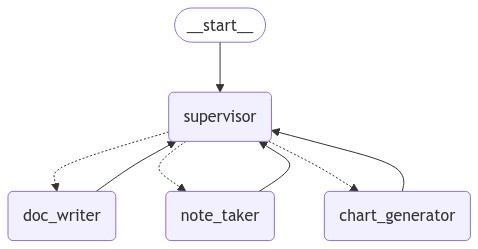

In [34]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [35]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    config
):
    print(s)
    print("---")

{'supervisor': {'messages': [HumanMessage(content='Write an outline for poem about cats and then write the poem to disk.', additional_kwargs={}, response_metadata={}, id='971c1b7f-6b9a-4344-bd7c-6d1ca0a44e60'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_R9ctgaUjxPh6Hc59CIod4TUF', 'function': {'arguments': '{}', 'name': 'transfer_to_note_taker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 106, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b592bf75-8318-43d9-906e-35c34a4d8bd2-0', tool_calls=[{'name': 'transfer_to_note_taker', 'args': {}, 'id': 'call_R9ctgaUjxPh6Hc59CIod4TUF', 'type'

In [28]:
WORKING_DIRECTORY

PosixPath('/var/folders/8w/jvdn7fb12sq4656f16qs8w9h0000gn/T/tmpkiye4f9d')

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [36]:
llm = ChatOpenAI(model="gpt-4o", model_kwargs=dict(parallel_tool_calls=False))

research_team_tool = handoff("research_team", tool_message="Transferred to research team", name="transfer_to_research_team", description="Transfer to research team")
paper_writing_team_tool = handoff("writing_team", tool_message="Transferred to writing team", name="transfer_to_writing_team", description="Transfer to writing team")

teams_supervisor_node = make_agent_node(
    llm, 
    [research_team_tool, paper_writing_team_tool], 
    state_schema=AgentRouterState,
    state_modifier="You are a supervisor tasked with managing a conversation between the following teams: ['research_team', 'writing_team']."
)


def call_research_team(state: AgentRouterState) -> AgentRouterState:
    # might actually need to pass full state here
    last_message_before_transfer = state["messages"][-3]
    response = research_graph.invoke({"messages": last_message_before_transfer})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="research_team")
        ]
    }


def call_paper_writing_team(state: AgentRouterState) -> AgentRouterState:
    # might actually need to pass full state here
    last_message_before_transfer = state["messages"][-3]
    response = paper_writing_graph.invoke({"messages": last_message_before_transfer})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="writing_team")
        ]
    }


# Define the graph.
super_builder = StateGraph(AgentRouterState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

# Define the control flow
super_builder.add_edge(START, "supervisor")
# We want our teams to ALWAYS "report back" to the top-level supervisor when done
super_builder.add_edge("research_team", "supervisor")
super_builder.add_edge("writing_team", "supervisor")
memory = MemorySaver()
super_graph = super_builder.compile(checkpointer=memory)

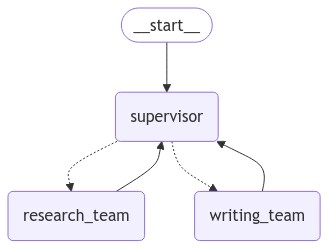

In [37]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [38]:
# super_graph.get_state(config).values["messages"]

In [40]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    config,
    subgraphs=True
):
    print(s)
    print("---")

(('supervisor:49653300-335a-2b86-deb3-b7a31d254118',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0XxzeKxefqyzG14Qzoyhr2g4', 'function': {'arguments': '{}', 'name': 'transfer_to_research_team'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 647, 'total_tokens': 660, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e8425c90-1453-476e-8667-de824d39f1ae-0', tool_calls=[{'name': 'transfer_to_research_team', 'args': {}, 'id': 'call_0XxzeKxefqyzG14Qzoyhr2g4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 647, 'output_tokens': 13, 'total_tokens': 660, 'input_token_details': {'audio